
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RichardJPovinelli/Neural_Networks_Course/blob/main/Dynamic_MLP_MNIST.ipynb)

In [ ]:
# Imports
import math, time, json, itertools, random
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

try:
    import ipywidgets as widgets
    from IPython.display import display

    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed()

In [ ]:
# Data Loaders (MNIST)
batch_size_default = 128
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
# Split train into train/val
val_size = 5000
train_size = len(train_ds) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)


def make_loaders(batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False),
        DataLoader(test_ds, batch_size=batch_size, shuffle=False),
    )


train_loader, val_loader, test_loader = make_loaders(batch_size_default)
print(f"Train: {train_size}, Val: {val_size}, Test: {len(test_ds)}")

Train: 55000, Val: 5000, Test: 10000



In [ ]:
# Dynamic MLP Model with optional BatchNorm, Dropout, Residual Blocks
class DynamicMLP(nn.Module):
    def __init__(
        self,
        input_dim=28 * 28,
        num_classes=10,
        hidden_width=256,
        depth=4,
        activation="relu",
        dropout=0.0,
        batchnorm=False,
        residual=False,
        widths_list=None,
    ):
        super().__init__()
        act_map = {
            "relu": nn.ReLU(),
            "gelu": nn.GELU(),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "leakyrelu": nn.LeakyReLU(0.2),
            "elu": nn.ELU(),
        }
        self.activation = act_map[activation.lower()]
        self.dropout_p = dropout
        self.batchnorm = batchnorm
        self.residual = residual
        if widths_list is not None and len(widths_list) > 0:
            widths = widths_list
            depth = len(widths)
        else:
            widths = [hidden_width] * depth
        self.input_dim = input_dim
        self.num_classes = num_classes
        layers = []
        prev = input_dim
        self.skip_dims = []
        for w in widths:
            block = []
            linear = nn.Linear(prev, w)
            block.append(linear)
            if batchnorm:
                block.append(nn.BatchNorm1d(w))
            block.append(self.activation)
            if self.dropout_p > 0:
                block.append(nn.Dropout(self.dropout_p))
            layers.append(nn.Sequential(*block))
            self.skip_dims.append((prev, w))
            prev = w
        self.layers = nn.ModuleList(layers)
        self.out = nn.Linear(prev, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = x
        for i, layer in enumerate(self.layers):
            inp = out
            out = layer(out)
            if self.residual:
                in_dim, out_dim = self.skip_dims[i]
                if in_dim == out_dim:
                    out = out + inp
        return self.out(out)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Quick sanity test
model_test = DynamicMLP(depth=3, hidden_width=128, activation="relu", residual=True)
print("Param count test model:", model_test.count_params())

Param count test model: 134794


In [ ]:
# Training Utilities
EXPERIMENT_LOG: list[dict] = []
@dataclass
class RunConfig:
    depth: int = 4
    hidden_width: int = 256
    activation: str = 'relu'
    dropout: float = 0.0
    batchnorm: bool = False
    residual: bool = False
    optimizer: str = 'adam'
    lr: float = 1e-3
    epochs: int = 5
    batch_size: int = 128
    scheduler: bool = False
    step_size: int = 3
    gamma: float = 0.5
    widths_list: list | None = None
    lm_max_iter: int = 20
    lm_history_size: int = 10

def make_model(cfg: RunConfig):
    return DynamicMLP(depth=cfg.depth, hidden_width=cfg.hidden_width, activation=cfg.activation,
                       dropout=cfg.dropout, batchnorm=cfg.batchnorm, residual=cfg.residual,
                       widths_list=cfg.widths_list).to(device)

def make_optimizer(cfg: RunConfig, params):
    opt_name = cfg.optimizer.lower()
    if cfg.scheduler and opt_name not in ('adamw', 'lm'):
        opt_name = 'adamw'
    if opt_name == 'lm':
        return torch.optim.LBFGS(
            params,
            lr=cfg.lr,
            max_iter=cfg.lm_max_iter,
            history_size=cfg.lm_history_size,
            line_search_fn='strong_wolfe'
        )
    if opt_name == 'sgd':
        return torch.optim.SGD(params, lr=cfg.lr, momentum=0.9)
    if opt_name == 'adamw':
        return torch.optim.AdamW(params, lr=cfg.lr)
    return torch.optim.Adam(params, lr=cfg.lr)

def make_scheduler(cfg: RunConfig, optimizer):
    if cfg.scheduler:
        if isinstance(optimizer, torch.optim.LBFGS):
            print('Scheduler skipped: not supported with LM optimizer.')
            return None
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.step_size, gamma=cfg.gamma)
    return None

def epoch_error_correct(logits, targets):
    preds = logits.argmax(dim=1)
    incorrect = (preds != targets).sum().item()
    return incorrect

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    uses_closure = is_train and isinstance(optimizer, torch.optim.LBFGS)
    if is_train:
        model.train()
    else:
        model.eval()
    total_loss, total_incorrect, total_samples = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if uses_closure:
            def closure():
                optimizer.zero_grad()
                logits_closure = model(xb)
                loss_closure = F.cross_entropy(logits_closure, yb)
                loss_closure.backward()
                return loss_closure
            loss = optimizer.step(closure)
            loss_value = loss.item() if torch.is_tensor(loss) else float(loss)
            with torch.no_grad():
                logits = model(xb)
        else:
            with torch.set_grad_enabled(is_train):
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            loss_value = loss.item()
        total_loss += loss_value * xb.size(0)
        total_incorrect += epoch_error_correct(logits, yb)
        total_samples += xb.size(0)
    avg_loss = total_loss / total_samples
    error_rate = total_incorrect / total_samples
    return avg_loss, error_rate

def summarize_run(cfg: RunConfig, history: dict, test_loss: float, test_error: float) -> dict:
    return {
        'run_id': len(EXPERIMENT_LOG) + 1,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'optimizer': history.get('optimizer_used', cfg.optimizer),
        'scheduler': history.get('scheduler_used', False),
        'depth': cfg.depth,
        'width': cfg.hidden_width if cfg.widths_list is None else str(cfg.widths_list),
        'activation': cfg.activation,
        'dropout': cfg.dropout,
        'batchnorm': cfg.batchnorm,
        'residual': cfg.residual,
        'epochs': cfg.epochs,
        'batch_size': cfg.batch_size,
        'best_val_error': min(history['val_error']) if history['val_error'] else float('nan'),
        'test_error': test_error,
        'test_loss': test_loss
    }

def run_experiment(cfg: RunConfig):
    train_loader, val_loader, test_loader = make_loaders(cfg.batch_size)
    model = make_model(cfg)
    optimizer = make_optimizer(cfg, model.parameters())
    scheduler = make_scheduler(cfg, optimizer)
    history = {'epoch': [], 'train_loss': [], 'train_error': [], 'val_loss': [], 'val_error': []}
    history['optimizer_used'] = 'lm' if isinstance(optimizer, torch.optim.LBFGS) else optimizer.__class__.__name__.lower()
    history['scheduler_used'] = scheduler is not None
    best_val_error = 1.0
    best_state = None
    for epoch in range(1, cfg.epochs + 1):
        tl, te = run_epoch(model, train_loader, optimizer)
        vl, ve = run_epoch(model, val_loader, None)
        if scheduler:
            scheduler.step()
        history['epoch'].append(epoch)
        history['train_loss'].append(tl)
        history['train_error'].append(te)
        history['val_loss'].append(vl)
        history['val_error'].append(ve)
        if ve < best_val_error:
            best_val_error = ve
            best_state = model.state_dict()
        print(f'Epoch {epoch}: TL={tl:.4f} TE={te:.4f} VL={vl:.4f} VE={ve:.4f}')
    if best_state is not None:
        model.load_state_dict(best_state)
    test_loss, test_error = run_epoch(model, test_loader, None)
    print(f'Test: loss={test_loss:.4f} error_rate={test_error:.4f}')
    history['test_loss'] = test_loss
    history['test_error'] = test_error
    EXPERIMENT_LOG.append(summarize_run(cfg, history, test_loss, test_error))
    return model, history

def plot_history(history, title='Training/Validation Error'):
    epochs = history['epoch']
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_error'], label='Train Error')
    plt.plot(epochs, history['val_error'], label='Val Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    print(f"Test Error: {history['test_error']:.4f}  Test Loss: {history['test_loss']:.4f}")

def plot_run_log(metric: str = 'test_error'):
    if not EXPERIMENT_LOG:
        print('No experiments logged yet.')
        return
    df = pd.DataFrame(EXPERIMENT_LOG)
    if metric not in df.columns:
        print(f"Metric '{metric}' not found in run log columns: {list(df.columns)}")
        return
    metric_title = metric.replace('_', ' ').title()
    plt.figure(figsize=(10,4))
    plt.bar(df['run_id'], df[metric], color='steelblue')
    plt.xlabel('Run ID')
    plt.ylabel(metric_title)
    plt.title(f'{metric_title} by Run')
    plt.xticks(df['run_id'])
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    display(df)

In [ ]:
# Interactive Widgets (if available)
if WIDGETS_AVAILABLE:
    depth_w = widgets.IntSlider(description='Depth', min=1, max=12, value=4)
    width_w = widgets.IntSlider(description='Width', min=32, max=1024, step=32, value=256)
    act_w = widgets.Dropdown(description='Activation', options=['relu','gelu','tanh','sigmoid','leakyrelu','elu'], value='relu')
    dropout_w = widgets.FloatSlider(description='Dropout', min=0.0, max=0.7, step=0.05, value=0.0)
    batchnorm_w = widgets.ToggleButton(description='BatchNorm', value=False)
    residual_w = widgets.ToggleButton(description='Residual', value=False)
    optimizer_w = widgets.Dropdown(description='Optimizer', options=['adam','adamw','sgd','lm'], value='adam')
    lr_w = widgets.FloatLogSlider(description='LR', base=10, min=-4, max=-1, step=0.1, value=1e-3)
    epochs_w = widgets.IntSlider(description='Epochs', min=1, max=20, value=5)
    batch_w = widgets.IntSlider(description='Batch', min=32, max=256, step=32, value=128)
    scheduler_w = widgets.ToggleButton(description='Scheduler', value=False)
    step_size_w = widgets.IntSlider(description='StepSize', min=1, max=10, value=3)
    gamma_w = widgets.FloatSlider(description='Gamma', min=0.1, max=0.9, step=0.05, value=0.5)
    lm_iter_w = widgets.IntSlider(description='LM max_iter', min=1, max=50, value=20)
    lm_hist_w = widgets.IntSlider(description='LM history', min=1, max=50, value=10)
    widths_text = widgets.Text(description='WidthsList', placeholder='e.g. 128,256,256')
    metric_dropdown = widgets.Dropdown(description='Metric', options=['test_error','best_val_error','test_loss'], value='test_error')
    run_button = widgets.Button(description='Run Experiment', button_style='success')
    out_area = widgets.Output()

    def on_run(b):
        with out_area:
            out_area.clear_output()
            if widths_text.value.strip():
                try:
                    wl = [int(x.strip()) for x in widths_text.value.split(',') if x.strip()]
                except ValueError:
                    print('Invalid widths list; using uniform width.')
                    wl = None
            else:
                wl = None
            cfg = RunConfig(
                depth=depth_w.value,
                hidden_width=width_w.value,
                activation=act_w.value,
                dropout=dropout_w.value,
                batchnorm=batchnorm_w.value,
                residual=residual_w.value,
                optimizer=optimizer_w.value,
                lr=lr_w.value,
                epochs=epochs_w.value,
                batch_size=batch_w.value,
                scheduler=scheduler_w.value,
                step_size=step_size_w.value,
                gamma=gamma_w.value,
                widths_list=wl,
                lm_max_iter=lm_iter_w.value,
                lm_history_size=lm_hist_w.value,
            )
            if cfg.optimizer.lower() == 'lm' and cfg.scheduler:
                print('Scheduler request ignored: LM optimizer does not support StepLR.')
            print('Running with config:', cfg)
            model, history = run_experiment(cfg)
            opt_label = history.get('optimizer_used', cfg.optimizer)
            plot_history(history, title=f'Error Curves (opt={opt_label}, depth={cfg.depth})')
            plot_run_log(metric_dropdown.value)

    run_button.on_click(on_run)
    display(
        widgets.VBox([
            widgets.HBox([depth_w, width_w, act_w, dropout_w]),
            widgets.HBox([batchnorm_w, residual_w, optimizer_w, lr_w]),
            widgets.HBox([epochs_w, batch_w, scheduler_w, step_size_w, gamma_w]),
            widgets.HBox([lm_iter_w, lm_hist_w, metric_dropdown]),
            widths_text,
            run_button,
            out_area,
        ])
    )
else:
    print('ipywidgets not available. Use manual config in next cell.')

### Run Configuration Parameters
- `depth`: number of hidden layers (ignored when `widths_list` is set; default 4).
- `hidden_width`: neurons per hidden layer when using uniform widths (default 256).
- `activation`: activation function name (`relu`, `gelu`, `tanh`, `sigmoid`, `leakyrelu`, `elu`).
- `dropout`: dropout probability applied after activations (0 disables).
- `batchnorm`: enable per-layer batch normalization (`True`/`False`).
- `residual`: add skip connections when layer dimensions align (`True`/`False`).
- `optimizer`: optimizer choice (`adam`, `adamw`, `sgd`, `lm`; `lm` uses an LBFGS-based Levenberg–Marquardt-like step and ignores schedulers).
- `lr`: learning rate supplied to the optimizer (default 1e-3).
- `epochs`: total training epochs (default 5).
- `batch_size`: mini-batch size used by data loaders (default 128).
- `scheduler`: toggle StepLR scheduler usage (`True`/`False`).
- `step_size`: StepLR step interval in epochs when scheduler is active (default 3).
- `widths_list`: optional explicit sequence of layer widths that overrides `hidden_width`/`depth`.

Launching example configuration: RunConfig(depth=4, hidden_width=256, activation='relu', dropout=0.1, batchnorm=True, residual=True, optimizer='adam', lr=0.001, epochs=5, batch_size=128, scheduler=False, step_size=3, gamma=0.5, widths_list=None, lm_max_iter=20, lm_history_size=10)
Epoch 1: TL=0.2054 TE=0.0627 VL=0.0987 VE=0.0316
Epoch 1: TL=0.2054 TE=0.0627 VL=0.0987 VE=0.0316
Epoch 2: TL=0.0947 TE=0.0291 VL=0.0820 VE=0.0260
Epoch 2: TL=0.0947 TE=0.0291 VL=0.0820 VE=0.0260
Epoch 3: TL=0.0704 TE=0.0232 VL=0.0739 VE=0.0210
Epoch 3: TL=0.0704 TE=0.0232 VL=0.0739 VE=0.0210
Epoch 4: TL=0.0597 TE=0.0199 VL=0.0748 VE=0.0240
Epoch 4: TL=0.0597 TE=0.0199 VL=0.0748 VE=0.0240
Epoch 5: TL=0.0454 TE=0.0147 VL=0.0706 VE=0.0226
Epoch 5: TL=0.0454 TE=0.0147 VL=0.0706 VE=0.0226
Test: loss=0.0713 error_rate=0.0215
Test: loss=0.0713 error_rate=0.0215


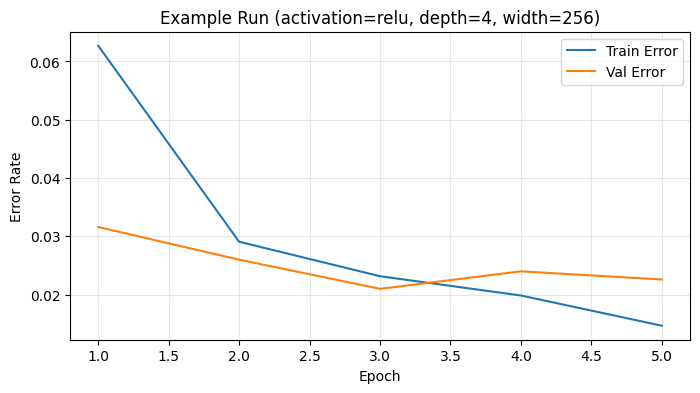

Test Error: 0.0215  Test Loss: 0.0713


In [ ]:
# Example training run on MNIST
example_cfg = RunConfig(
    depth=4,
    hidden_width=256,
    activation='relu',
    dropout=0.1,
    batchnorm=True,
    residual=True,
    optimizer='adam',
    lr=1e-3,
    epochs=5,
    batch_size=128,
    scheduler=False
)
print('Launching example configuration:', example_cfg)
example_model, example_history = run_experiment(example_cfg)
plot_history(
    example_history,
    title=f"Example Run (activation={example_cfg.activation}, depth={example_cfg.depth}, width={example_cfg.hidden_width})"
)
plot_run_log('test_error')